In [ ]:
!pip install gensim


In [ ]:
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense


In [ ]:
imdb = tf.keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=None)

# Combine original splits
all_data = np.concatenate((train_data, test_data), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Custom split (change test_size=0.3 for 70-30)
X_train, X_test, y_train, y_test = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)


In [ ]:
import numpy as np

print("Training set distribution:")
print("Positive reviews:", np.sum(y_train == 1))
print("Negative reviews:", np.sum(y_train == 0))

print("\nTest set distribution:")
print("Positive reviews:", np.sum(y_test == 1))
print("Negative reviews:", np.sum(y_test == 0))


Training set distribution:
Positive reviews: 20000
Negative reviews: 20000

Test set distribution:
Positive reviews: 5000
Negative reviews: 5000


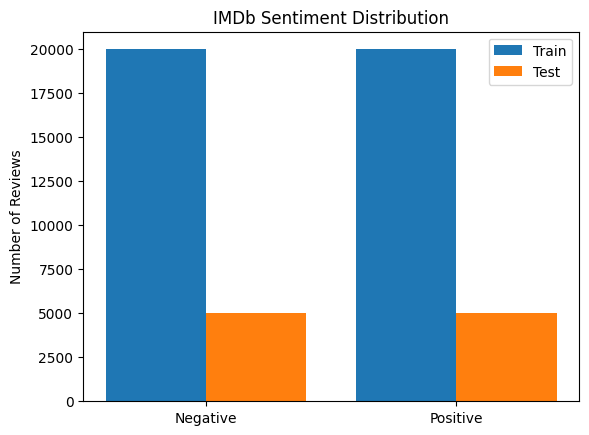

In [ ]:
import matplotlib.pyplot as plt

labels = ['Negative', 'Positive']
train_counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
test_counts = [np.sum(y_test == 0), np.sum(y_test == 1)]

x = np.arange(len(labels))

plt.bar(x - 0.2, train_counts, 0.4, label='Train')
plt.bar(x + 0.2, test_counts, 0.4, label='Test')
plt.xticks(x, labels)
plt.ylabel("Number of Reviews")
plt.title("IMDb Sentiment Distribution")
plt.legend()
plt.show()


In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = {v+3: k for k, v in word_index.items()}
reverse_word_index.update({0: '<PAD>', 1: '<START>', 2: '<UNK>', 3: '<UNUSED>'})

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

train_text = [decode_review(x) for x in X_train]
test_text  = [decode_review(x) for x in X_test]


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return tokens




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_tokens = [preprocess(t) for t in train_text]

test_tokens  = [preprocess(t) for t in test_text]

In [ ]:
train_tokens

[['start',
  'watching',
  'tipping',
  'velvet',
  'sarah',
  'water',
  'decided',
  'watch',
  'character',
  'good',
  'performance',
  'though',
  'missing',
  'rachael',
  'stirling',
  'adaptation',
  'story',
  'line',
  'overall',
  'good',
  'choice',
  'twisting',
  'character',
  'amazing',
  'excellent',
  'watch',
  'missing',
  'rachael',
  'stirling',
  'enjoy',
  'romance',
  'two',
  'girl',
  'one',
  'best',
  'film',
  'watch',
  'take',
  'different',
  'spin',
  'tipping',
  'velvet',
  'good',
  'would',
  'recommend',
  'everyone'],
 ['start',
  'eight',
  'jean',
  'rollin',
  'film',
  'watched',
  'also',
  'possibly',
  'weirdest',
  'intriguing',
  'plot',
  'seems',
  'initially',
  'flimsy',
  'sustain',
  'even',
  'trim',
  'minute',
  'somehow',
  'contrives',
  'get',
  'inordinately',
  'muddled',
  'go',
  'along',
  'would',
  'female',
  'vampire',
  'scantily',
  'clad',
  'promised',
  'title',
  'held',
  'captivity',
  'inside',
  'remote',
 

In [ ]:
len(train_tokens)

40000

In [ ]:
len(train_tokens[0])

46

In [ ]:
len(train_tokens[1])

120

In [ ]:
w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)


In [ ]:
def vectorize(tokens):
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

X_train_vec = np.array([vectorize(t) for t in train_tokens])
X_test_vec  = np.array([vectorize(t) for t in test_tokens])


In [ ]:
params = {'var_smoothing': np.logspace(-9, -6, 50)}

nb = GaussianNB()
rs_nb = RandomizedSearchCV(nb, params, n_iter=10, cv=3, verbose=2, n_jobs=-1)
rs_nb.fit(X_train_vec, y_train)

nb_preds = rs_nb.predict(X_test_vec)

print("Best NB Params:", rs_nb.best_params_)
print("NB Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best NB Params: {'var_smoothing': np.float64(8.685113737513521e-07)}
NB Accuracy: 0.7738
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      5000
           1       0.77      0.78      0.78      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(t) for t in train_tokens])

X_train_seq = tokenizer.texts_to_sequences([' '.join(t) for t in train_tokens])
X_test_seq  = tokenizer.texts_to_sequences([' '.join(t) for t in test_tokens])

max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [ ]:
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [ ]:
rnn_model = Sequential([
    Embedding(len(word_index)+1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.fit(X_train_pad, y_train, epochs=10, validation_split=0.2)

rnn_preds = (rnn_model.predict(X_test_pad) > 0.5).astype(int)
print("RNN Accuracy:", accuracy_score(y_test, rnn_preds))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 55ms/step - accuracy: 0.5144 - loss: 0.6969 - val_accuracy: 0.5255 - val_loss: 0.6891
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5272 - loss: 0.6840 - val_accuracy: 0.5235 - val_loss: 0.6827
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - accuracy: 0.5280 - loss: 0.6801 - val_accuracy: 0.5205 - val_loss: 0.6853
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5265 - loss: 0.6777 - val_accuracy: 0.5285 - val_loss: 0.6812
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - accuracy: 0.5946 - loss: 0.6465 - val_accuracy: 0.5195 - val_loss: 0.6889
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.5333 - loss: 0.6832 - val_accuracy: 0.5476 - val_loss: 0.6795
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.5837 - loss: 0.6595 - val_accuracy: 0.6905 - val_loss: 0.6178
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.6858 -

In [ ]:
lstm_model = Sequential([
    Embedding(len(word_index)+1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_pad, y_train, epochs=10, validation_split=0.2)

lstm_preds = (lstm_model.predict(X_test_pad) > 0.5).astype(int)
print("LSTM Accuracy:", accuracy_score(y_test, lstm_preds))
print(classification_report(y_test, lstm_preds))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 103s 98ms/step - accuracy: 0.5683 - loss: 0.6607 - val_accuracy: 0.5294 - val_loss: 0.6715
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 102s 102ms/step - accuracy: 0.5594 - loss: 0.6795 - val_accuracy: 0.5190 - val_loss: 0.6846
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - accuracy: 0.5672 - loss: 0.6679 - val_accuracy: 0.5326 - val_loss: 0.6819
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 102s 102ms/step - accuracy: 0.5643 - loss: 0.6659 - val_accuracy: 0.6137 - val_loss: 0.6508
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 99s 99ms/step - accuracy: 0.6372 - loss: 0.6314 - val_accuracy: 0.5443 - val_loss: 0.6722
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 99s 99ms/step - accuracy: 0.6425 - loss: 0.5859 - val_accuracy: 0.8711 - val_loss: 0.3125
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - accuracy: 0.8695 - loss: 0.3220 - val_accuracy: 0.8739 - val_loss: 0.2988
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy:

In [ ]:
import joblib

joblib.dump(rs_nb.best_estimator_, "naive_bayes_w2v.pkl")


['naive_bayes_w2v.pkl']

In [ ]:
rnn_model.save("rnn_sentiment_model.h5")


In [ ]:
lstm_model.save("lstm_sentiment_model.h5")


In [ ]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [ ]:
w2v_model.save("word2vec.model")


In [26]:
import numpy as np
print(np.__version__)


2.0.2


In [28]:
import sys
import numpy as np
import tensorflow as tf
import nltk
import gensim
import sklearn
import joblib
# import streamlit
import scipy
import pandas
import matplotlib

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("NLTK version:", nltk.__version__)
print("Gensim version:", gensim.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Joblib version:", joblib.__version__)
# print("Streamlit version:", streamlit.__version__)
print("SciPy version:", scipy.__version__)
print("Pandas version:", pandas.__version__)
print("Matplotlib version:", matplotlib.__version__)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy version: 2.0.2
TensorFlow version: 2.19.0
NLTK version: 3.9.1
Gensim version: 4.4.0
Scikit-learn version: 1.6.1
Joblib version: 1.5.3
SciPy version: 1.16.3
Pandas version: 2.2.2
Matplotlib version: 3.10.0
